In [23]:
import pandas as pd
import numpy as np
from googletrans import Translator
import string
import time

from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import json
import numbers
import multiprocessing
from itertools import product
RND_STATE = 515991

%matplotlib inline

## 0. Config

In [24]:
max_string_length = 500
output_csv = 'data_converted.csv'

In [25]:
def log_progress(sequence, every=None, size=None, name='Processed'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [26]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

## 1. Loading data

### 1.1 Loading and decoding data

In [27]:
data = pd.read_csv('123.csv', sep=',', encoding='utf8')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data_length_start = len(data)
print('Initial length: {0}'.format(data_length_start))
data.describe()

Initial length: 24733


,from,from_id,message,picture,link,name,description,type,created_time,shares,post_id
count,24643,24621,17456,22342,22861,19305,7533,24564,24562,13340,24558
unique,757,744,14711,18236,18901,5899,6114,18,21051,294,21301
top,Russian Tour,_75258759941,Buonanotte!,https://external.xx.fbcdn.net/safe_image.php?d...,http://www.russiantour.com/,Timeline Photos,Russian Gateway Tours,photo,2013-10-09T01:00:00+0000,1,792410744188300_947573222005384
freq,6130,6130,87,217,18,5015,74,16296,14,3119,2


## 2. Preprocessing

### 2.1 Removing nans and unnecessary columns

In [28]:
data = data.drop(['picture', 'link', 'from_id', 'post_id'], axis=1)
data[['shares']] = data[['shares']].fillna(value=0)
data = data.dropna(how='all')
data = data.dropna(subset=['message'])
print('Removed {0} elements'.format(data_length_start - len(data)))
print('New length is {0}'.format(len(data)))

Removed 7277 elements
New length is 17456


### 2.2 Removing emojis, links and numbers

emojis

In [29]:
data['message'] = data['message'].str.replace(u'[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]', '')
data['description'] = data['description'].str.replace(u'[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]', '')

links

In [30]:
data['message'] = data['message'].str.replace(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '')
data['description'] = data['message'].str.replace(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '')

numbers

In [31]:
data['message'] = data['message'].str.replace(r'\b\d+\b','')
data['description'] = data['message'].str.replace(r'\b\d+\b','')

special chars

In [32]:
data['message'] = data['message'].str.replace('"', '')
data['message'] = data['message'].str.replace('#', '')

data['description'] = data['description'].str.replace('"', '')
data['description'] = data['description'].str.replace('#', '')

### 2.3 Removing advertisements

In [33]:
data = data[~data['from'].str.contains("Visit-Petersburg", na=False)]
print('Removed {0} elements'.format(data_length_start - len(data)))
print('New length is {0}'.format(len(data)))
data.describe()

Removed 8247 elements
New length is 16486


,from,message,name,description,type,created_time,shares
count,16486,16486,13512,16486,16442,16440,16486
unique,599,13460,3853,13460,17,14442,292
top,Russian Tour,,Timeline Photos,,photo,2013-10-09T01:00:00+0000,0
freq,4480,286,4344,286,10983,14,6912


### 2.4 Stripping texts and converting types

In [34]:
def convert_column_int(column):
    converted = []
    for value in column.values:
        if str(value).isdigit():
            converted.append(value)
        else:
            converted.append(0)
    return converted

In [35]:
data['message'] = data['message'].apply(lambda x: x[:max_string_length].strip())
data['description'] = data['message'].apply(lambda x: x[:max_string_length].strip())

In [36]:
data['shares'] = convert_column_int(data['shares'])
data[['shares']] = data[['shares']].apply(pd.to_numeric)

### 2.5 Translating texts into english

In [43]:
def translate_big_text(texts_source, dest = 'en', chunk_size = 500, delay=0):
    translated = []
    chunks_list = list(chunks(texts_source, chunk_size))
    i = 1
    for chunk in log_progress(chunks_list):
        translated.extend(translate_big_text_internal(chunk)) 
        print('Translated chunk #{0} of {1}'.format(i, len(chunks_list)))
        print('Waiting {0} sec'.format(delay))
        time.sleep(delay)
        i += 1 
    return translated

In [44]:
def translate(text, dest='en'):
    translator = Translator()
    translated = ''
    try:
        translated = translator.translate(u''.join(text), dest=dest).text
    except Exception as e:
        print(e)
    return translated

In [45]:
def translate_big_text_internal(texts_source, dest='en'):
    with multiprocessing.Pool(processes=30) as pool:
        results = pool.starmap(translate, product(texts_source))
    
    print('Number of errors: ', results.count(''))
    return results

In [46]:
msg_translations = translate_big_text(data['message'].values)

A Jupyter Widget

Number of errors:  2
Translated chunk #1 of 33
Waiting 0 sec
Number of errors:  4
Translated chunk #2 of 33
Waiting 0 sec
Number of errors:  18
Translated chunk #3 of 33
Waiting 0 sec
Number of errors:  16
Translated chunk #4 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #5 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #6 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #7 of 33
Waiting 0 sec
Number of errors:  12
Translated chunk #8 of 33
Waiting 0 sec
Number of errors:  26
Translated chunk #9 of 33
Waiting 0 sec
Number of errors:  15
Translated chunk #10 of 33
Waiting 0 sec
Number of errors:  2
Translated chunk #11 of 33
Waiting 0 sec
Number of errors:  3
Translated chunk #12 of 33
Waiting 0 sec
Number of errors:  106
Translated chunk #13 of 33
Waiting 0 sec
Number of errors:  16
Translated chunk #14 of 33
Waiting 0 sec
Number of errors:  24
Translated chunk #15 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #16 of 33
Waiting 0 sec
Number o

In [47]:
data['message'] = msg_translations

In [57]:
print('Number of skipped = ', 290)

Number of skipped =  290


In [49]:
descr_translations = translate_big_text(data['description'].values)

A Jupyter Widget

Number of errors:  2
Translated chunk #1 of 33
Waiting 0 sec
Number of errors:  4
Translated chunk #2 of 33
Waiting 0 sec
Number of errors:  18
Translated chunk #3 of 33
Waiting 0 sec
Number of errors:  16
Translated chunk #4 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #5 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #6 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #7 of 33
Waiting 0 sec
Number of errors:  12
Translated chunk #8 of 33
Waiting 0 sec
Number of errors:  26
Translated chunk #9 of 33
Waiting 0 sec
Number of errors:  15
Translated chunk #10 of 33
Waiting 0 sec
Number of errors:  2
Translated chunk #11 of 33
Waiting 0 sec
Number of errors:  3
Translated chunk #12 of 33
Waiting 0 sec
Number of errors:  106
Translated chunk #13 of 33
Waiting 0 sec
Number of errors:  16
Translated chunk #14 of 33
Waiting 0 sec
Number of errors:  24
Translated chunk #15 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #16 of 33
Waiting 0 sec
Number o

In [50]:
data['description'] = descr_translations

In [56]:
print('Number of skipped = ', 290)

Number of skipped =  290


In [52]:
names_translations = translate_big_text(data['from'].values)

A Jupyter Widget

Number of errors:  0
Translated chunk #1 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #2 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #3 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #4 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #5 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #6 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #7 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #8 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #9 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #10 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #11 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #12 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #13 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #14 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #15 of 33
Waiting 0 sec
Number of errors:  0
Translated chunk #16 of 33
Waiting 0 sec
Number of errors:

In [53]:
data['from'] = names_translations

In [55]:
print('Number of skipped = ', 0)

Number of skipped =  0


## 2.7 Moving all words to lower case

In [59]:
data["message"] = data["message"].map(lambda x: x if type(x)!=str else x.lower())
data["description"] = data["description"].map(lambda x: x if type(x)!=str else x.lower())

### 2.8 Tokenizing sentences

In [61]:
data['message'] = data['message'].apply(lambda x: nltk.word_tokenize(str(x)))
data['description'] = data['description'].apply(lambda x: nltk.word_tokenize(str(x)))

### 2.9 Removing stopwords and punctuation

In [62]:
stop_words = stopwords.words('english')
stop_words += (['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '\n', '/n', '-', '#', 'visitpetersburg', 'visitrussia', 'russia', 'the', 'is', 'a'])

In [63]:
data['message'] = data['message'].apply(lambda x: list(filter(lambda y: y not in stop_words, x)))
data['description'] = data['description'].apply(lambda x: list(filter(lambda y: y not in stop_words, x)))

In [64]:
data['message'] = data['message'].apply(lambda x: " ".join(x))
data['description'] = data['description'].apply(lambda x: " ".join(x))

### 2.10 Saving data to file

In [66]:
def save_csv():
    data.to_csv(output_csv, index=False)

In [67]:
def parse_csv_tuple(series):
    values = series.values
    parsed = []
    for value in values:
        parsed.append(json.loads(value.replace("'",'"')))
    return parsed

In [68]:
def load_csv():
    loaded_data = pd.read_csv(output_csv, sep=',', encoding='utf8')
    loaded_data['message_sentiment_vader'] = parse_csv_tuple(loaded_data['message_sentiment_vader'])
    loaded_data['description_sentiment_vader'] = parse_csv_tuple(loaded_data['description_sentiment_vader'])
    return loaded_data

In [69]:
save_csv()

# 3. Processing data

## 3.1 Trying to guess gender by name

In [70]:
detector = gender.Detector(case_sensitive=False)

In [71]:
data['from_gender'] = [detector.get_gender((str(name)).split(' ')[0]) for name in data['from'].values]

In [72]:
data['from_gender'].replace([0],['unknown'],inplace=True)

## 3.1 Getting sentiments by Vader algorithm

In [73]:
sid = SentimentIntensityAnalyzer()
message_sent = []
descr_sent = []
data['message'].apply(lambda x: message_sent.append(sid.polarity_scores((x))));
data['description'].apply(lambda x: descr_sent.append(sid.polarity_scores((x))));
data['message_sentiment_vader'] = message_sent
data['description_sentiment_vader'] = descr_sent

In [74]:
def get_message_sentiment(series, border_line=0.2):
    values = series.values
    parsed_values = []
    for value in values:
        if value['neg'] >= border_line:
            parsed_values.append('negative')
        elif value['pos'] >= border_line:
            parsed_values.append('positive')
        else:
            parsed_values.append('neutral')
    return parsed_values

In [75]:
data['message_sentiment_vader_parsed'] = get_message_sentiment(data['message_sentiment_vader'])
data['description_sentiment_vader_parsed'] = get_message_sentiment(data['description_sentiment_vader'])

In [76]:
save_csv()

## 3.2 Plotting stats 

### 3.2.1 Shares per gender

In [82]:
data.groupby(['from_gender']).sum()

,shares
from_gender,
andy,1
female,2166
male,6877
mostly_female,0
mostly_male,512
unknown,227183


#### 3.2.1.1 Row data

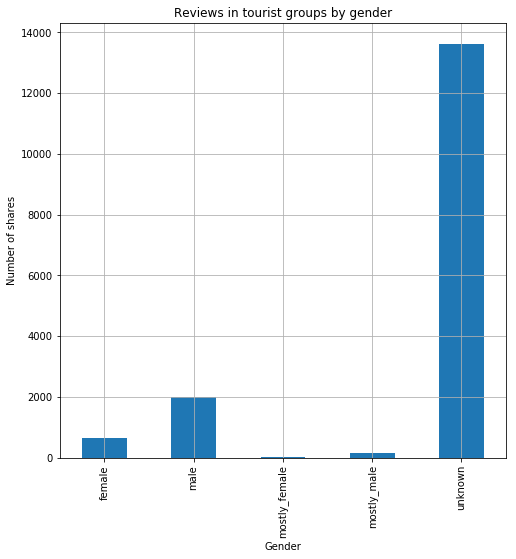

In [83]:
groups = data.groupby(['from_gender']).size()
groups = groups.drop(['andy'], axis=0)
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of shares');

#### 3.2.1.2 Only genders

In [122]:
groups = data.groupby(['from_gender']).size()
groups = groups.drop(['andy', 'unknown'], axis=0)
groups['female'] += groups['mostly_female']
groups['male'] += groups['mostly_male']
groups = groups.drop(['mostly_female', 'mostly_male'], axis=0)

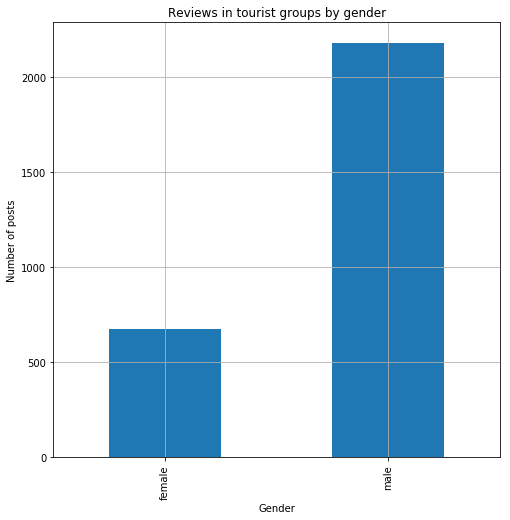

In [123]:
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of posts');

### 3.2.2 Messages sentiments

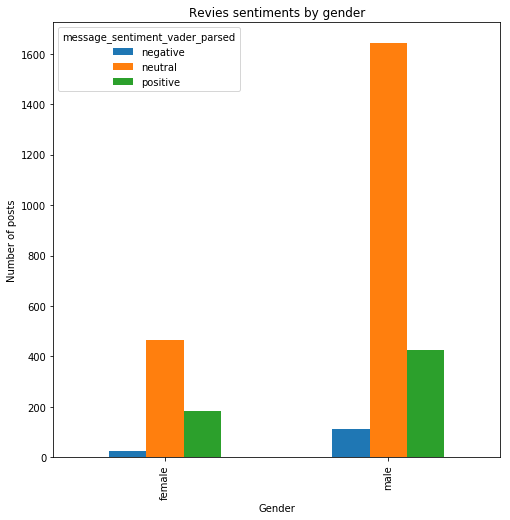

In [120]:
data_tmp = data.copy()
data_tmp = data_tmp.replace({"from_gender": {'mostly_female': 'female', 'mostly_male': 'male', 'andy': 'unknown'}})
data_tmp = data_tmp[data_tmp['from_gender'] != 'unknown']
# groups = data.groupby(['from_gender', 'message_sentiment_vader_parsed']).size()
ax = pd.crosstab(data_tmp['from_gender'], 
                 data_tmp['message_sentiment_vader_parsed']).plot.bar(title = 'Revies sentiments by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of posts');